In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
plt.rcParams["figure.figsize"] = [15.0, 10.0]

# Lecture 10: Neural Networks
## 11/13/18

### Table Of Contents
1. [Activations and the Motivation behind Neural Networks](#section1)  
    1.1 [Function Composition](#section1.1)  
    1.2 [Nonlinear Demo](#section1.2)  
    1.3 [Other Activation Functions](#section1.3)  
    1.4 [How Neural Networks learn](#section1.4)  
2. [Neural Networks](#section2)  
    2.1 [The Single Neuron](#section2.1)  
    2.2 [Feedforward](#section2.2)
3. [Gradient Descent, Learning](#section3) <br>
    3.1 [Gradient Descent Algorithm](#section3.1) <br>
    3.2 [Loss Functions](#section3.2) <br>
    3.3 [Softmax](#section3.3) <br>
    3.4 [Regularization, Dropout](#section3.4) <br>
4. [Intro to Keras](#section4) <br>
    4.1 [Understanding the MNIST Dataset](#section4.1) <br>
    4.2 [The Sequential Model](#section4.2) <br>
    4.3 [Compilation](#section4.3) <br>
    4.4 [Training](#section4.4) <br>
    4.5 [Evaluation](#section4.5) <br>
    4.6 [Prediction](#section4.6) <br>
    4.7 [Examples of Mis-Classified images](#section4.7)

### Hosted by and maintained by the [Statistics Undergraduate Students Association (SUSA)](http://susa.berkeley.edu) (Authored by Ajay Raj)

<a id='section1'></a>
## Activations and the Motivation behind Neural Networks

So far, you've been exposed to **linear models** (and decision trees, which aren't really linear or nonlinear, but that's beside the point). That is, the models you've seen look as follows:

$$h(x) = f(w^T x + b)$$

Here, $h(x)$ is your prediction for the training point $x$, and $f$ is some function that maps the output of the affine function $w^T x + b$ to look like the output space. For example, for a classification task, you could take the sign of the output (if positive, return class 1, if negative, return class 0).

However, if you remember, you can try to learn **nonlinear functions** by having **nonlinear features**. For example, if you are trying to use regression to fit to a polynomial of a single feature $x$, $f(x) = a_0 x^0 + a_1 x^1 + a_2 x^2 + ... + a_n x^n$, then you can use linear regression if you transform your feature $x$ into the features $\begin{bmatrix} x^0 & x^1 & ... & x^n \end{bmatrix}$.

In the real world, however, you don't know if your data is polynomial, or sinusoidal, etc., so you do **not** know the transformation to **nonlinear features** needed to fit your model.

<a id='section1.1'></a>
### Function Composition

*There is no way to "increase the complexity" of a linear model* i.e. linear models can never get more complicated than a linear combination of the features. That is, even if you chain together a bunch of linear functions, the complexity of the model will not increase.

Say that your features are $x_1, ..., x_n$ and two linear functions $f$ and $g$. Your model for $y = h(x_1, ..., x_n)$ could be $f(g(x_1, ..., x_n))$, but since $f$ and $g$ are of the form $f(x_1, ..., x_n) = \sum a_i x_i$ and $g(x_1, ..., x_n) = \sum b_i x_i$, the output of the composition will be $\sum c_i x_i$, so there was no added complexity of chaining these two "learned" functions together.

However, compositions of **nonlinear functions** *do* increase the complexity of the overall model.

<a id='section1.2'></a>

### Nonlinear Demo

Say we are trying to learn the function $f(x) = \cos{x}$ on the interval $[-\pi, \pi]$. (Note: for this demo, we'll assume that the training points $x$ are centered about 0 for convenience).

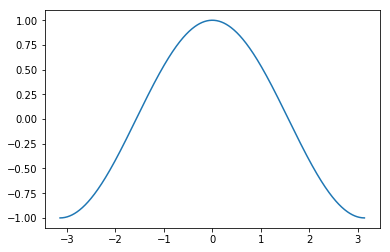

In [2]:
x = np.arange(-np.pi, np.pi, 0.01)
y = np.cos(x)

plt.plot(x, y)
xlim = plt.xlim()
ylim = plt.ylim()

##### ReLU (Rectified Linear Unit)

The most simple nonlinear function is called **ReLU** or rectified linear unit, and is defined as $\text{ReLU}(x) = \max(0, x)$.

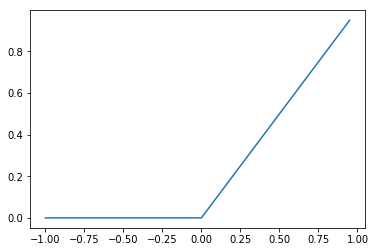

In [3]:
x_relu = np.arange(-1, 1, 0.05)
plt.plot(x_relu, np.maximum(x_relu, np.zeros(x_relu.shape)));

We will use ReLUs to approximate this function, with the model (where $N$ is the number of ReLU or linear units:

$$\hat{y}_1 = \sum_{i = 1}^N a_i \cdot \text{ReLU}(b_i + c_i \cdot x)$$

We'll contrast this model with another that can only use linear functions:

$$\hat{y}_2 = \sum_{i = 1}^N a_i \cdot (b_i + c_i \cdot x)$$

In [4]:
from relus import train

f_nonlinear = train(x, y, mode='nonlinear')
f_linear = train(x, y, mode='linear')

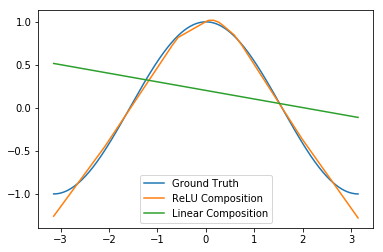

In [5]:
y_hat_nonlinear = np.zeros(y.shape)
y_hat_linear = np.zeros(y.shape)
for i, x_i in enumerate(x):
    y_hat_nonlinear[i] = f_nonlinear(x_i)
    y_hat_linear[i] = f_linear(x_i)
plt.plot(x, y, label='Ground Truth')
plt.plot(x, y_hat_nonlinear, label='ReLU Composition')
plt.plot(x, y_hat_linear, label='Linear Composition')
plt.legend();

As you can see, the nonlinear composition model just blew the linear composition model out of the water! This is a **huge** deal, because it means we can now learn complex functions with composition of linear functions (and not by *manually* introducing features). Here's a GIF of the ReLUs being trained:

<img src='IMAGES/relus.gif'></img>

In fact, the **universal approximation theorem** says that you can use function composition with nonlinear functions to approximate *any* continuous function (with a few extra mild assumptions). As we increase the number of ReLUs we use, we can get arbitrarily close to any continuous function.

<img src='IMAGES/neurons.gif'></img>

The primary idea behind neural networks is using **nonlinear function composition** to *learn* the best features for the model.

<a id='section1.3'></a>
### Other Activation Functions

In neural networks, these nonlinear functions are called **activation functions**. Here are some other commonly used activation functions:

$\textit{Sigmoid}$ is useful if you want only positive numbers. It is also the activation function that was used to introduce the idea of neural networks.
<img src = "IMAGES/sigmoid.png" style="width:300px;height:250px">
$\textit{Tanh}$ has many advantages over sigmoid since the activation function is centered at zero, and can output negative numbers. 
<img src = "IMAGES/tanh.png" style="width:300px;height:250px">
$\textit{ReLU}$ (Rectified Linear Unit) is one of the most common activation functions used—you saw this earlier. In practice, $\textit{ReLU}$ is often preferred over sigmoid and tanhbecause of the [vanishing gradient problem](https://en.wikipedia.org/wiki/Vanishing_gradient_problem).
<img src = "IMAGES/relu.png" style="width:300px;height:250px">

<a id='section2'></a>

## Neural Networks
Neural networks derive their name from the neural network we have in our head, our brain. In a very highly simplified model, the brain is a collection of neurons that receives electrical input signals from dendrites, outputting electrical signals via a single axon. Each neuron sends signals along a single axon and connects with other dendrites. 

<img src= "IMAGES/neuron_connection.gif">


Neural networks attempt to model this by having artificial layers neurons that perform minor tasks, then communicate from layer to layer. The collection of neurons operate together to begin to understand the raw input in layers - in each layer, the neurons summarize the data a little bit further, until they finally arrive at a single label.
This sums up the feed forward neural network, which is what we'll be exploring today.

Note: **feed forward** means that the neural network does not have any cycles. Neural networks with cycles (recurrent neural networks, for example) are very interesting, but we won't be covering them today.

<a id='section2.1'></a>
### The Single Neuron

Every neural network is comprised of many neurons connected with weights. The neuron itself is the backbone of the network, and each neuron accomplishes the following tasks:
1. Receives information through weights pointing to that neural multiplied by the neuron the weight originated from.
2. Applies the activation function $f$ to the sum of the weights multiplied by the previous neuron.
3. Outputs this value to the next set of neurons.

<img src= "IMAGES/biological_neuron.jpeg">


The diagram above shows a single neuron taking in other neurons' outputs $x_0$, $x_1$ and $x_2$ with weights $w_0$, $w_1$ and $w_2$, respectively. The output from the neuron is labeled as the output axon. The function $f$ is the activation function.

<a id='section2.2'></a>
### Feedforward 
Most neural networks with the goal of classification or regression follow the feedforward model. The feedforward model always contains three essential parts.
1. Inputs
2. Hidden Layers
3. Output (or result)

An example of a feedforward neural network is shown below.


<img src= "IMAGES/feedforward.png">



In the diagram of a neural network shown above, the circles represent neurons, and the arrows represent the communication, or weights, between neurons. All neurons must connect to all neurons in the next layer.

#### Intuitively, a feedforward neural network can consist of three levels with corresponding neurons:
    
1.	**Input Layer**: Each neuron in the layer represents each of the features of a training point.
2.	**Hidden Layer** – The Hidden layers contain neurons that move numbers from the input neurons to the output neurons. They take in the inputs from the input layer. The number of neurons in the hidden layers are determined by the user (they are a hyperparameter!). There can be as many hidden layers as necessary depending on the problem.
3.	**Output Layer** – The neurons in the output layer are the results that the NN returns. 

Let's return to our example from earlier, where $y = \cos{x}$ and $h(x) = \hat{y} = \sum_{i = 1}^N a_i \cdot \text{ReLU}(b_i + c_i \cdot x)$. This is actually a neural network with one hidden layer!

<img src= "IMAGES/1 Layer NN.png">

<a id='section3'></a>
## Gradient Descent, Learning

Before we talk about how a neural network updates its weights, let's talk about optimization problems in machine learning more generally. An **unconstrained optimization problem** is the following:

$$\min_{x \in \mathbb{R}^n} f(x)$$

If $f(x)$ is **convex** (don't worry too much about this), you can find the minimum by taking the derivative and setting the expression equal to zero.

For example, if $f(x) = ax^2 + bx + c$, $\frac{df}{dx} = 2ax + b = 0$, so the point $\frac{-b}{2a}$ minimizes the function. However, it is often too difficult to solve the derivative equation, so instead, we perform an **online optimization** algorithm called **gradient descent**.

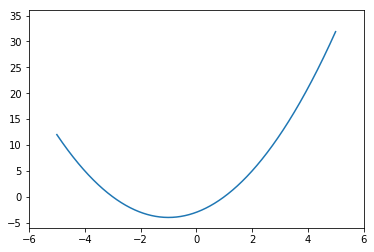

In [6]:
a = 1
b = 2
c = -3

x = np.arange(-5, 5, 0.01)
y = a*np.square(x) + b*x + c

plt.xlim((-6, 6))
plt.ylim((-6, 36))
plt.plot(x, y);

Say that we start at the point $x = 3$. Let's examine the **tangent line** at $x = 3$.

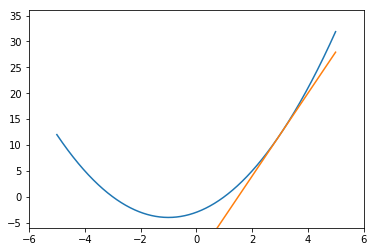

In [7]:
tangent = (a*9 + b*3 + c) + (2*a*3 + b)*(x - 3)

plt.xlim((-6, 6))
plt.ylim((-6, 36))
plt.plot(x, y)
plt.plot(x, tangent);

A tangent line is also known as a **linear approximation** of a function. We should move our $x$ towards where the tangent line hits 0. It turns out that if we move our $x$ in the opposite direction of the derivative, then we'll hit the minimum!

In our case, we are trying to solve the optimization problem:

$$\min_{\text{model weights  } w} L(w)$$

$w$ are the weights of our model, and $L$ is **loss** of our model as it predicts on our training data.

**Gradient descent** says that we should slowly move the weights $w$ in the opposite direction of the derivative of the loss.

<a id='section3.1'></a>
### Gradient Descent Algorithm

If we start at some model $w^{(0)}$, we can improve it with the following update.

$$w^{(t)} = w^{(t - 1)} - \epsilon \nabla_w L(w)$$

$\nabla_w L(w)$ is called the **gradient** of the function $L$ at $w$: don't worry about this, think of it as a derivative of a vector. $\epsilon$ is called the **learning rate**, or the size of each step you're moving your weights.

Here's an animation of gradient descent finding the minimum of a function in 3D represented by a contour plot.

<img src='IMAGES/gradient_descent.gif'></img>

<a id='section3.2'></a>
### Loss Functions

After a **forward pass** of your model, you create predictions for each of your training points $\hat{y}_1, ..., \hat{y}_n$. A loss function $L(y, \hat{y})$ is how you evaluate how well you model performed on the data.

There are many losses to choose from: we'll focus on two today, for two separate tasks.

For **regression**, which you've learned is predicting a **continuous** output variable, we often use **mean squared error**, which you've seen because it's the loss using linear regression.

$$L(y, \hat{y}) = \sum_{i = 1}^n (y_i - \hat{y}_i)^2$$

For **classification**, which you'll be doing on the project and later in this lecture, you can use **categorical cross-entropy loss**, where $y_{ik}$ is 1 if the $i$th training point is in class $k$, 0 otherwise, and ${\hat {y}}_{ik}$ is the model's probability that that the $i$th training point is in class $k$.

$$L(y, \hat{y}) = -\sum_{i = 1}^n \sum_{\text{class } k} y_{ik} \log {\hat {y}}_{ik}$$

The key thing to notice about the cross-entropy loss is that the loss drastically increases as the probability for the correct label approaches zero. If we output a very low probability for the correct class, the logarithm approaches very large negative values, resulting in a large loss. On the other hand, if we output a very high probability close to $1$ for the correct class, the loss is almost zero since $\log 1 = 0$.

<a id='section3.3'></a>
### Softmax (Classification)

After you do your forward pass through your many neurons, you'll want to have the last layer be the number of classes in the output. Intuitively, the highest value in any of the neurons for a specific training point should be class that is predicted.

However, in order to use **categorical cross-entropy loss** you need the probability that your training point is in each specific class, $\hat{y}_{ik}$. So, we take these scores $s_1, ..., s_k$, and map them to:

$$\hat{y}_{ik} = \frac{e^{s_k}}{\sum e^{s_k}}$$

This is called the **softmax** activation function, and it maps scores into a **probability distribution** over the classes. **Softmax** is crucial for most classification tasks in deep learning.

<a id='section3.4'></a>
### Regularization, Dropout

Since we can develop extremely complex models with neural networks, we need to perform **regularization** so we don't overfit. One thing you can do is to change the loss function so that it looks like **ridge regression** or **LASSO regression**, but you can also add **dropout**.

Dropout means to randomly drop edges in the forward pass during training, so that only certain neurons are activated in a forward pass. This has an ensemble effect on the model, because you're now learning many different models, and in testing, you're essentially **averaging** their effects.

We now look at a specific example of a deep learning architecture through the MNIST Dataset, which is sort of the hello world example in deep learning.

<a id='section4'></a>
# Intro to Keras

<a id='section4.1'></a>
### Understanding the MNIST Dataset
The MNIST dataset consists of 70k images, 60k of which are considered the training set, with the remaining 10k for test. Each data entry $X_i$ in the MNIST dataset is a $28\times28$ pixel image of a single handwritten digit, and each is labeled with the associated digit between $0$ and $9$, denoted as $y_i$. Our goal is to design a model that learns a classification scheme from the 60k training images $\{X_i\}$ and their labels $\{y_i\}$, and then perform well in predicting which digit is represented in each test image.

#### Check for Understanding
>How many different classes (e.g. different kinds of labels) are present in the MNIST dataset? <br>
> Can you think of a particular pair of numbers that might be particularly difficult to differentiate, or prone to misclassification with each other?

#### Acquiring the MNIST Dataset
The MNIST data actually comes packaged with keras, a package which we will be using later to implement our deep learning model, by default. So, let's install keras and take a look at the dataset.



In [8]:
from keras.datasets import mnist
num_classes = 10
# The data, shuffled and split between tran and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()
print("X_train original shape", X_train.shape)
print("y_train original shape", y_train.shape)

Using TensorFlow backend.


11493376/11490434 [==============================] - 6s 1us/step
X_train original shape (60000, 28, 28)
y_train original shape (60000,)


#### Structure of MNIST
We can verify that the data entries $X$ of train consist of $60,000$ images of $28\times28$ pixels in size. These entries come with labels $y_i$, one for each image $X_i$. A similar setup can be seen for the $10,000$ entries in test.

Each image $X_i$ is represented by a two-dimensional array (i.e. $28\times28$ matrix) of grayscale intensities ranging from $[0,255]$ to indicate the darkness of the ink at each pixel. $0$ represents a pixel that is completely white, and $255$ represents a pixel that is completely black.

#### Check for understanding
> What does each $y_i$ represent, with respect to the corresponding $X_i$? What are the possible values for $y_i$?

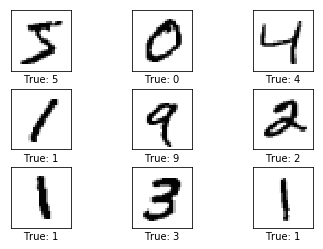

In [9]:
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape((28, 28)), cmap='binary')
        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])
        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show();
    
plot_images(X_train[0:9], y_train[0:9])

<a id='section4.2'></a>
### Data Preprocessing
The model we are working with requires flatten our two-dimensional arrays of $28\times28$ pixels into $28\times28=784$-dimensional vectors. For our label vector $y$, we use to_categorical to one-hot-encode our labels - this command transforms our scalars $y_i \in [0,9]$ into binary class vectors $y'_i$.

In [11]:
# reshape 2d (28x28) image data into 1d vectors (28x28 = 784-d vectors)
X_train = X_train.reshape(X_train.shape[0], 784)
X_test = X_test.reshape(X_test.shape[0], 784)

In [12]:
import keras
# convert class labels into vectors. Ie 3 -> [0,0,0,1,0,0,0,0,0,0]
y_train_oe = keras.utils.to_categorical(y_train, num_classes)
y_test_oe = keras.utils.to_categorical(y_test, num_classes)

In [13]:
import keras
from keras.models import Sequential
from keras.layers import Dense

<a id='section4.2'></a>
### The Sequential Model
The Sequential Model is a Linear Stack of Layers. You can add layers with the .add() method

In [14]:
model = Sequential()

#### Specifying the input shape
The model needs to know what input shape it should expect. For this reason, the first layer in a Sequential model (and only the first, because following layers can do automatic shape inference) needs to receive information about its input shape. 

In [15]:
model.add(Dense(30, activation='relu', input_shape=(784,)))
model.add(Dense(num_classes, activation='softmax'))

<img src="IMAGES/softmax.png">

<a id='section4.3'></a>
### Compilation
Before training a model, you need to configure the learning process, which is done via the compile method. It receives three arguments:

*   An optimizer. This could be the string identifier of an existing optimizer (such as rmsprop or adagrad), or an instance of the Optimizer class. 
*   A loss function. This is the objective that the model will try to minimize. It can be the string identifier of an existing loss function (such as categorical_crossentropy or mse), or it can be an objective function. See: losses.

*   A list of metrics. For any classification problem you will want to set this to metrics=['accuracy']. A metric could be the string identifier of an existing metric or a custom metric function.


In [16]:
# For a mean squared error regression problem
model.compile(optimizer='sgd', #How to Learn
              loss='mse') #What to Learn
# For a binary classification problem
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
# For a multi-class classification problem
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

<a id='section4.4'></a>
### Training
Now that the model has been fully defined with loss-function and optimizer, we can train it. This function takes numpy-arrays and performs the given number of training epochs using the given batch-size. An epoch is one full use of the entire training-set. So for 10 epochs we would iterate randomly over the entire training-set 10 times

In [17]:
model.fit(x=X_train, y=y_train_oe, epochs=10, batch_size=128)

Epoch 1/10
60000/60000 [==============================] - 2s 27us/step - loss: 4.1904 - accuracy: 0.7166
Epoch 2/10
60000/60000 [==============================] - 1s 23us/step - loss: 0.6465 - accuracy: 0.8567
Epoch 3/10
60000/60000 [==============================] - 1s 22us/step - loss: 0.4947 - accuracy: 0.8890
Epoch 4/10
60000/60000 [==============================] - 1s 23us/step - loss: 0.4156 - accuracy: 0.9075
Epoch 5/10
60000/60000 [==============================] - 1s 23us/step - loss: 0.3677 - accuracy: 0.9149
Epoch 6/10
60000/60000 [==============================] - 1s 23us/step - loss: 0.3289 - accuracy: 0.9229
Epoch 7/10
60000/60000 [==============================] - 1s 23us/step - loss: 0.3033 - accuracy: 0.9287
Epoch 8/10
60000/60000 [==============================] - 1s 23us/step - loss: 0.2860 - accuracy: 0.9314
Epoch 9/10
60000/60000 [==============================] - 1s 24us/step - loss: 0.2710 - accuracy: 0.9351
Epoch 10/10
60000/60000 [==============================

<a id='section4.5'></a>
### Evaluation
Now that the model has been trained we can test its performance on the test-set. This also uses numpy-arrays as input.

In [18]:
result = model.evaluate(x=X_test, y=y_test_oe)
print("Evaluation error: %f \nTest accuracy: %f" % (result[0], result[1] * 100))

10000/10000 [==============================] - 0s 39us/step
Evaluation error: 0.375272 
Test accuracy: 93.180001


<a id='section4.6'></a>
### Prediction
We can also predict the classification for new images. We will just use some images from the test-set but you could load your own images into numpy arrays and use those instead.

In [23]:
y_pred = model.predict(x=X_test)

Then we convert the predicted class-numbers from One-Hot encoded arrays to integers.

In [24]:
cls_pred = np.argmax(y_pred, axis=1)
print(cls_pred[:5])

[7 2 1 0 4]


<a id='section4.7'></a>
### Examples of Mis-Classified Images
We can plot some examples of mis-classified images from the test-set.

In [25]:
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape((28, 28)), cmap='binary')
        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])
        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show();

In [26]:
def plot_example_errors(cls_pred):
    # cls_pred is an array of the predicted class-number for all images in the test-set.
    # Boolean array whether the predicted class is incorrect.
    incorrect = (cls_pred != y_test)
    # Get the images from the test-set that have been
    # incorrectly classified.
    images = X_test[incorrect]
    # Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]
    # Get the true classes for those images.
    cls_true = y_test[incorrect]
    # Plot the first 9 images.
    plot_images(images=images[0:9],
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])

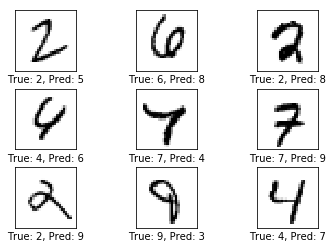

In [27]:
plot_example_errors(cls_pred)

### Sources Cited
https://ujjwalkarn.me/2016/08/09/quick-intro-neural-networks/

https://becominghuman.ai/deep-learning-made-easy-with-deep-cognition-403fbe445351?gi=306188a6ff43

http://www.saedsayad.com/artificial_neural_network.htm

https://www.neuraldesigner.com/blog/perceptron-the-main-component-of-neural-networks

https://www.researchgate.net/figure/Examples-of-2s-in-the-MNIST-database-first-100-examples-Note-the-very-diverse_fig1_2540340